In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
import sys

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.0


In [2]:
cifar10_data = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10_data.load_data()

In [3]:
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

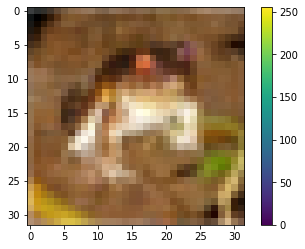

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
train_images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [6]:
train_images = train_images / 255.0

test_images = test_images / 255.0

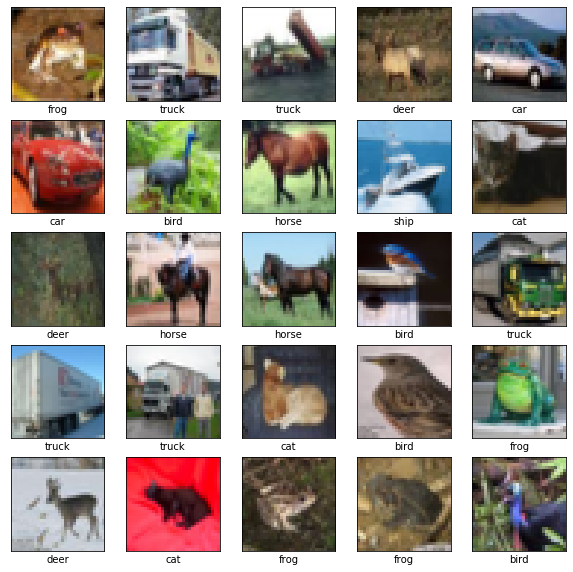

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [8]:
train_images.shape

(50000, 32, 32, 3)

In [9]:
"""ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](
    https://arxiv.org/abs/1512.03385) (CVPR 2016 Best Paper Award)
Adapted from code contributed by BigMoyan.
"""
import os
import warnings

backend = tf.keras.backend
layers = tf.keras.layers
models = tf.keras.models
keras_utils = tf.keras.utils


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')


    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 256], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 256], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 256], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 256], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 512], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 512], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 512], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 512], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 512], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 512], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 1024], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 1024], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 1024], stage=5, block='c')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='resnet50')

    return model

In [10]:
model = ResNet50(include_top=False, input_shape=(32, 32, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/mao/.virtualenvs/tf_quantization/lib/python3.6/site-packages/ipykernel_launcher.py:226: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.


In [9]:
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(32, 32, 3)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
# ])
model = keras.applications.MobileNetV2(include_top=False, input_shape=(32, 32, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/mao/.virtualenvs/tf_quantization/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [10]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [17]:
model = keras.applications.VGG16(include_top=False, input_shape=(32, 32, 3))

In [18]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [11]:
dropout=1e-3
shape = (1, 1, 1280)
model = keras.Sequential([model,
                         keras.layers.GlobalAveragePooling2D(),
                         keras.layers.Dense(512, activation='relu'),
                         keras.layers.Dense(128, activation='relu'),
                         keras.layers.Dense(10)
                         ])

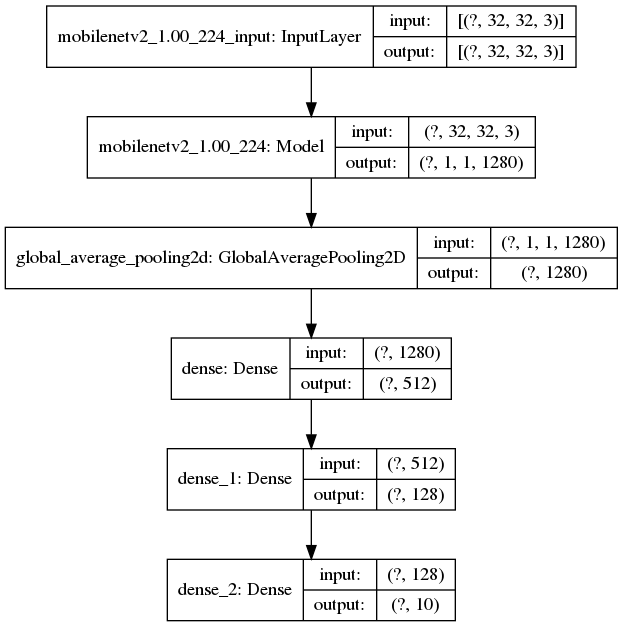

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 2,980,810
Trainable params: 2,946,698
Non-trainable params: 34,112
_________________________________________________________________


In [15]:
model.fit(train_images, train_labels, epochs=15)

Train on 50000 samples
Epoch 1/15
50000/50000 [==============================] - 37s 735us/sample - loss: 1.2897 - acc: 0.5654
Epoch 2/15
50000/50000 [==============================] - 32s 640us/sample - loss: 0.9360 - acc: 0.6943
Epoch 3/15
50000/50000 [==============================] - 33s 667us/sample - loss: 0.8231 - acc: 0.7318
Epoch 4/15
50000/50000 [==============================] - 32s 639us/sample - loss: 0.7540 - acc: 0.7521
Epoch 5/15
50000/50000 [==============================] - 32s 640us/sample - loss: 0.6946 - acc: 0.7719
Epoch 6/15
50000/50000 [==============================] - 32s 641us/sample - loss: 0.6351 - acc: 0.7915
Epoch 7/15
50000/50000 [==============================] - 32s 641us/sample - loss: 0.5921 - acc: 0.8071
Epoch 8/15
50000/50000 [==============================] - 32s 641us/sample - loss: 0.5466 - acc: 0.8210
Epoch 9/15
50000/50000 [==============================] - 32s 640us/sample - loss: 0.5181 - acc: 0.8302
Epoch 10/15
50000/50000 [================

In [16]:
model.save('./model/mobilenetv2.h5')

In [17]:
# mobilenetv2_inference
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 3s - loss: 0.7143 - acc: 0.7756

Test accuracy: 0.7756


In [17]:
# mobilenetv1 inference
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 2s - loss: 0.6955 - acc: 0.7672

Test accuracy: 0.7672


In [19]:
# resnet50_1 inference
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 5s - loss: 1.5225 - acc: 0.4400

Test accuracy: 0.44


In [17]:
# resnet50 inference
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 7s - loss: 0.9176 - acc: 0.7619

Test accuracy: 0.7619


In [17]:
# vgg16 inference
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/10000 - 4s - loss: 0.8179 - acc: 0.7597

Test accuracy: 0.7597


In [18]:
predictions = model.predict(test_images)

In [19]:
predictions[0]

array([-2.2491949 , -4.490459  , -1.5163604 ,  6.0226607 ,  0.78217036,
        2.5847738 ,  1.6738353 , -0.27451923, -3.4205    , -1.7516617 ],
      dtype=float32)

In [20]:
np.argmax(predictions[0])

3

In [21]:
test_labels[0]

array([3], dtype=uint8)

In [22]:
np.max(predictions[0]) * 100

602.2660732269287

In [23]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i][0]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

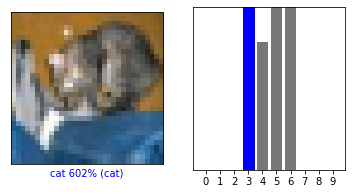

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

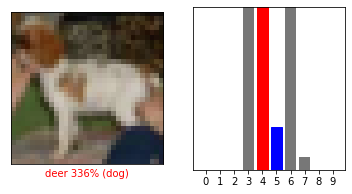

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

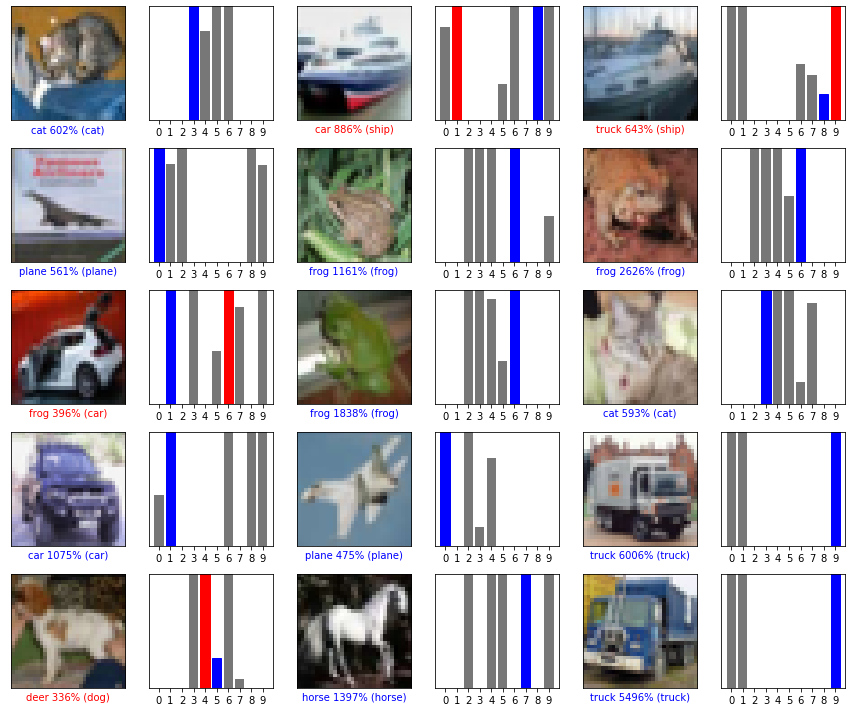

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [27]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(32, 32, 3)


In [28]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 32, 32, 3)


In [29]:
predictions_single = model.predict(img)

print(predictions_single)

[[ 0.8234856   8.857731   -0.4180687  -1.4535022  -7.538208    0.31998608
   1.1561276  -2.6054378   2.8544264   4.034419  ]]


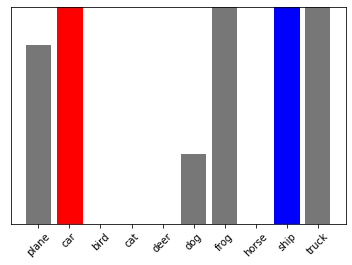

In [30]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [31]:
np.argmax(predictions_single[0])

1